In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# DB connect
DB_PATH = "../data/vaccination.db"
conn = sqlite3.connect(DB_PATH)

print("[INFO] Connected to:", DB_PATH)

# helper functions
def run_query(query):
    df = pd.read_sql(query, conn)
    print(f"[QUERY OK] Returned {len(df)} rows")
    return df

def show(df, n=5, title=""):
    print(f"\n--- {title} (showing {n} rows) ---")
    display(df.head(n))

def plot_chart(df, x, y, kind="line", title=""):
    if df.empty:
        print("⚠️ No data to plot")
        return
    df.plot(x=x, y=y, kind=kind, figsize=(8,4), title=title)
    plt.show()

# ✅ Test query to confirm everything is working
test_q = "SELECT name FROM sqlite_master WHERE type='table';"
df_test = run_query(test_q)
show(df_test, 10, "Tables available in vaccination.db")


[INFO] Connected to: ../data/vaccination.db
[QUERY OK] Returned 7 rows

--- Tables available in vaccination.db (showing 10 rows) ---


,name
0,dim_country
1,fact_coverage
2,sqlite_sequence
3,fact_incidence
4,fact_cases
5,dim_vaccine_intro
6,dim_schedule


In [3]:
# ---------- Cell 1: Setup & Helpers ----------
%matplotlib inline
import os, sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from IPython.display import display

plt.rcParams["figure.figsize"] = (10,5)

# EDIT THIS if your DB path is different:
DB_PATH = r"C:\JN\Vaccination-Project\data\vaccination.db"

if not os.path.exists(DB_PATH):
    raise FileNotFoundError(f"DB not found at {DB_PATH}. Update DB_PATH.")

print("[INFO] Using DB:", DB_PATH)

# helpers
def run_query(q, params=None):
    with sqlite3.connect(DB_PATH) as conn:
        return pd.read_sql(q, conn, params=params)

def show(df, n=8, title=None):
    if title:
        print("=== ", title, " ===")
    if df is None or df.shape[0]==0:
        print("No rows.")
    else:
        display(df.head(n))
        print("Shape:", df.shape)

def plot_line(x, y, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(x, y, marker='o')
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    plt.grid(alpha=0.2)
    plt.show()

def plot_scatter(x, y, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(7,5))
    plt.scatter(x, y, alpha=0.6)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    plt.grid(alpha=0.2)
    plt.show()

def safe_pearson(a, b):
    df = pd.concat([a,b], axis=1).dropna()
    if df.shape[0] < 2:
        return None
    try:
        return pearsonr(df.iloc[:,0], df.iloc[:,1])[0]
    except:
        return None

print("Helpers ready.")

[INFO] Using DB: C:\JN\Vaccination-Project\data\vaccination.db
Helpers ready.


In [4]:
# ---------- Cell 2: Show tables and row counts ----------
tables = run_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
display(tables)

for t in ["fact_coverage","fact_incidence","fact_cases","dim_vaccine_intro","dim_schedule","dim_country"]:
    try:
        cnt = run_query(f"SELECT COUNT(*) AS cnt FROM {t};")['cnt'][0]
    except Exception:
        cnt = "N/A"
    print(f"{t}: {cnt}")


,name
0,dim_country
1,dim_schedule
2,dim_vaccine_intro
3,fact_cases
4,fact_coverage
5,fact_incidence
6,sqlite_sequence


fact_coverage: 399859
fact_incidence: 84946
fact_cases: 84870
dim_vaccine_intro: 138321
dim_schedule: 3212
dim_country: 0


===  Q1: Measles coverage vs incidence (sample)  ===


,iso3,country,year,coverage,incidence
0,ABW,Aruba,2022,91.59,0.0
1,ABW,Aruba,2022,91.59,0.0
2,ABW,Aruba,2022,83.02,0.0
3,ABW,Aruba,2022,83.02,0.0
4,ABW,Aruba,2021,93.86,0.0
5,ABW,Aruba,2021,93.86,0.0
6,ABW,Aruba,2021,76.45,0.0
7,ABW,Aruba,2021,76.45,0.0


Shape: (1000, 5)


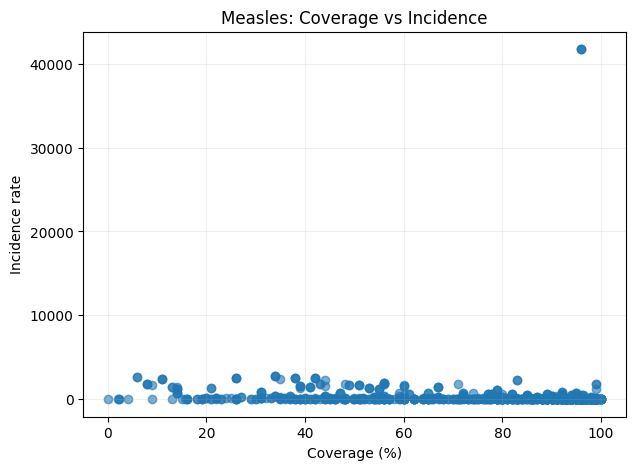

Pearson correlation: -0.048


In [5]:
# Q1
q = """
SELECT c.iso3, c.country_name AS country, c.year AS year, c.coverage_percent AS coverage, i.incidence_rate AS incidence
FROM fact_coverage c
JOIN fact_incidence i
  ON c.iso3 = i.iso3 AND c.year = i.year
WHERE (c.antigen LIKE '%MCV%' OR c.antigen_desc LIKE '%Measles%')
  AND i.disease_desc LIKE '%Measles%'
  AND c.coverage_percent IS NOT NULL
  AND i.incidence_rate IS NOT NULL
LIMIT 1000;
"""
df = run_query(q)
show(df, 8, "Q1: Measles coverage vs incidence (sample)")

if df.shape[0] >= 2:
    plot_scatter(df['coverage'], df['incidence'], xlabel="Coverage (%)", ylabel="Incidence rate", title="Measles: Coverage vs Incidence")
    corr = safe_pearson(df['coverage'], df['incidence'])
    print("Pearson correlation:", round(corr,3) if corr is not None else "Not enough data")
else:
    print("Not enough joined rows to compute correlation.")


In [6]:
# Q2
# We'll identify dose1/dose2 using coverage_category_desc or antigen_desc heuristics.
q = "SELECT iso3, country_name, year, antigen, antigen_desc, coverage_category_desc, coverage_percent FROM fact_coverage WHERE coverage_percent IS NOT NULL LIMIT 200000;"
df_all = run_query(q)

def detect_dose(row):
    text = " ".join([str(row.get('coverage_category_desc','') or ''), str(row.get('antigen_desc','') or '' )]).lower()
    if any(k in text for k in ['dose 1','first dose','1st dose','dose1','d1']):
        return 'dose1'
    if any(k in text for k in ['dose 2','second dose','2nd dose','dose2','d2','booster']):
        return 'dose2'
    return None

df_all['dose'] = df_all.apply(detect_dose, axis=1)
pairs = df_all.dropna(subset=['dose']).pivot_table(index=['iso3','country_name','year','antigen'], columns='dose', values='coverage_percent', aggfunc='mean').reset_index()
pairs = pairs.dropna(subset=['dose1','dose2'], how='any').copy()
pairs['dose1'] = pd.to_numeric(pairs['dose1'], errors='coerce')
pairs['dose2'] = pd.to_numeric(pairs['dose2'], errors='coerce')
pairs['drop_off'] = pairs['dose1'] - pairs['dose2']
show(pairs.sort_values('drop_off', ascending=False), 8, "Q2: Detected dose1-dose2 drop-offs (top)")

if pairs.shape[0] > 0:
    plot_line(pairs.groupby('year')['drop_off'].mean().reset_index()['year'], pairs.groupby('year')['drop_off'].mean().reset_index()['drop_off'],
              xlabel="Year", ylabel="Avg drop-off (pp)", title="Avg Drop-off (Dose1 - Dose2) by Year")
    print("Average drop-off overall:", round(pairs['drop_off'].mean(),2))
else:
    print("No detectable dose1/dose2 pairs found in data.")

===  Q2: Detected dose1-dose2 drop-offs (top)  ===
No rows.
No detectable dose1/dose2 pairs found in data.


In [7]:
# Q3
print("Dataset does NOT contain gender-split fields. Returning proxy: country-level averages.")
q = "SELECT country_name, AVG(coverage_percent) AS avg_cov, COUNT(*) AS n FROM fact_coverage WHERE coverage_percent IS NOT NULL GROUP BY country_name HAVING COUNT(*)>30 ORDER BY avg_cov DESC;"
df_q3 = run_query(q)
show(df_q3, 8, "Q3: Country-level avg coverage (proxy for gender analysis not available)")

print("Top 5 countries by avg coverage:")
display(df_q3.head(5))
print("Bottom 5 countries by avg coverage:")
display(df_q3.tail(5))


Dataset does NOT contain gender-split fields. Returning proxy: country-level averages.
===  Q3: Country-level avg coverage (proxy for gender analysis not available)  ===


,country_name,avg_cov,n
0,Monaco,96.459530,383
1,Hungary,96.099107,929
2,Turkmenistan,95.490906,1016
3,"occupied Palestinian territory, including east...",95.343862,668
4,Cuba,94.935866,1108
5,Saint Kitts and Nevis,94.416165,991
6,Slovakia,93.893790,868
7,Albania,93.861438,1231


Shape: (243, 3)
Top 5 countries by avg coverage:


,country_name,avg_cov,n
0,Monaco,96.459530,383
1,Hungary,96.099107,929
2,Turkmenistan,95.490906,1016
3,"occupied Palestinian territory, including east...",95.343862,668
4,Cuba,94.935866,1108


Bottom 5 countries by avg coverage:


,country_name,avg_cov,n
238,African Region,35.131783,645
239,Least developed,34.461938,578
240,Gavi 5.0 yes,34.425957,601
241,Low income,33.522481,1290
242,West and Central Africa,29.159734,601


⚠️ Education data not present. Using WHO region as proxy (from dim_country).
===  Q4: Avg Coverage by WHO Region  ===


,who_region,avg_cov
0,Unknown,77.100558


Shape: (1, 2)


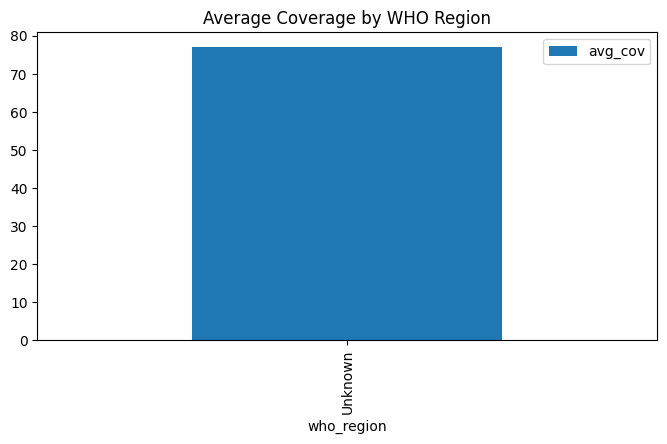

📊 Highest Coverage Region: Unknown → 77.1 %
📉 Lowest Coverage Region: Unknown → 77.1 %


In [15]:
print("⚠️ Education data not present. Using WHO region as proxy (from dim_country).")

q4 = """
SELECT COALESCE(c.who_region,'Unknown') AS who_region,
       AVG(f.coverage_percent) AS avg_cov
FROM fact_coverage f
LEFT JOIN dim_country c 
  ON f.iso3 = c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.who_region
ORDER BY avg_cov DESC;
"""

df_q4 = run_query(q4)

# show aggregated result
show(df_q4, 10, "Q4: Avg Coverage by WHO Region")

if df_q4.empty:
    print("⚠️ No WHO region data available in the database.")
else:
    # chart
    plot_chart(df_q4, x="who_region", y="avg_cov", kind="bar", title="Average Coverage by WHO Region")

    # text insight
    print("📊 Highest Coverage Region:", df_q4.iloc[0]["who_region"], 
          "→", round(df_q4.iloc[0]["avg_cov"], 2), "%")
    print("📉 Lowest Coverage Region:", df_q4.iloc[-1]["who_region"], 
          "→", round(df_q4.iloc[-1]["avg_cov"], 2), "%")


Urban/Rural not explicit. Using dim_schedule.geoarea as proxy where available.
===  Q5: Coverage by geoarea (proxy for urban/rural)  ===


,geoarea,avg_cov,n
0,SUBNATIONAL,80.849879,5950
1,NATIONAL,80.847129,164996
2,None,76.932780,215025


Shape: (3, 3)


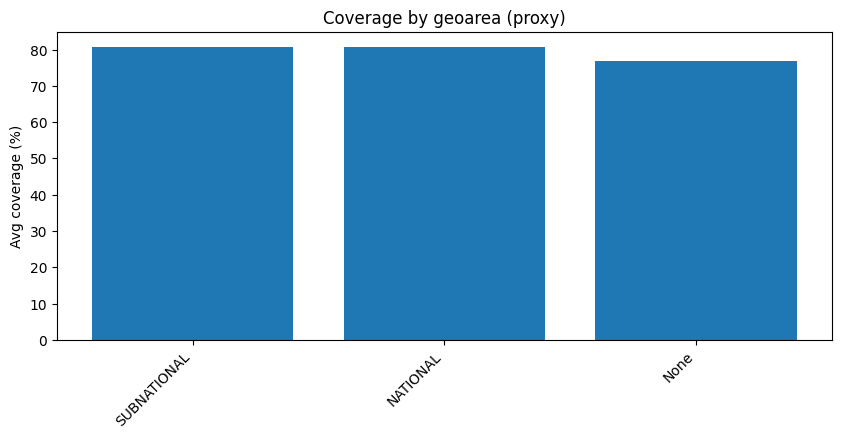

In [8]:
# Q5
print("Urban/Rural not explicit. Using dim_schedule.geoarea as proxy where available.")
q = """
SELECT s.geoarea, AVG(f.coverage_percent) AS avg_cov, COUNT(*) AS n
FROM fact_coverage f
LEFT JOIN dim_schedule s ON f.iso3 = s.iso3 AND f.year = s.year
WHERE f.coverage_percent IS NOT NULL
GROUP BY s.geoarea
ORDER BY avg_cov DESC;
"""
df_q5 = run_query(q)
show(df_q5, 20, "Q5: Coverage by geoarea (proxy for urban/rural)")

if not df_q5.empty:
    plt.figure(figsize=(10,4))
    plt.bar(df_q5['geoarea'].astype(str), df_q5['avg_cov'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Avg coverage (%)"); plt.title("Coverage by geoarea (proxy)")
    plt.show()

===  Q6: Schedule entries and booster mentions by year  ===


,year,entries,boosters,booster_pct
0,NaN,1,0,0.0
1,2019.0,38,0,0.0
2,2021.0,11,0,0.0
3,2022.0,31,0,0.0
4,2023.0,3131,0,0.0


Shape: (5, 4)


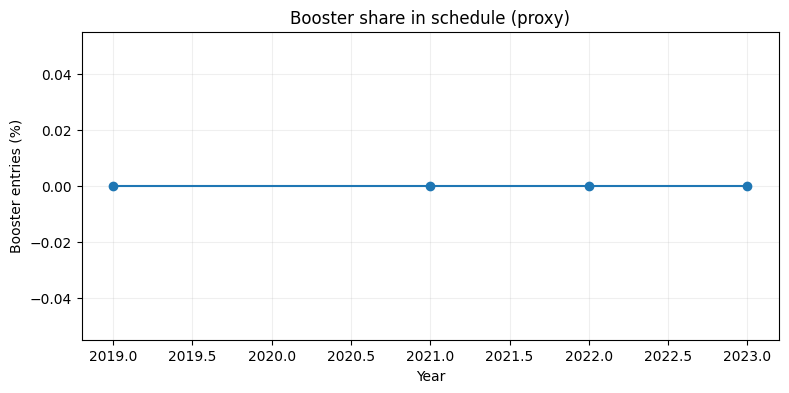

In [9]:
# Q6
q = """
SELECT year, COUNT(*) AS entries, SUM(CASE WHEN LOWER(schedule_round) LIKE '%booster%' THEN 1 ELSE 0 END) AS boosters
FROM dim_schedule
GROUP BY year
ORDER BY year;
"""
df_q6 = run_query(q)
df_q6['booster_pct'] = 100.0 * df_q6['boosters'] / df_q6['entries']
show(df_q6, 20, "Q6: Schedule entries and booster mentions by year")

plot_line(df_q6['year'], df_q6['booster_pct'], xlabel="Year", ylabel="Booster entries (%)", title="Booster share in schedule (proxy)")

Dataset is yearly — monthly seasonality cannot be detected. Showing yearly averages.
===  Q7: Yearly avg coverage  ===


,year,avg_cov
0,1980,44.250829
1,1981,46.115658
2,1982,48.783593
3,1983,52.860714
4,1984,53.969494
5,1985,56.147923
6,1986,60.240541
7,1987,63.739984
8,1988,67.413137
9,1989,70.747811


Shape: (44, 2)


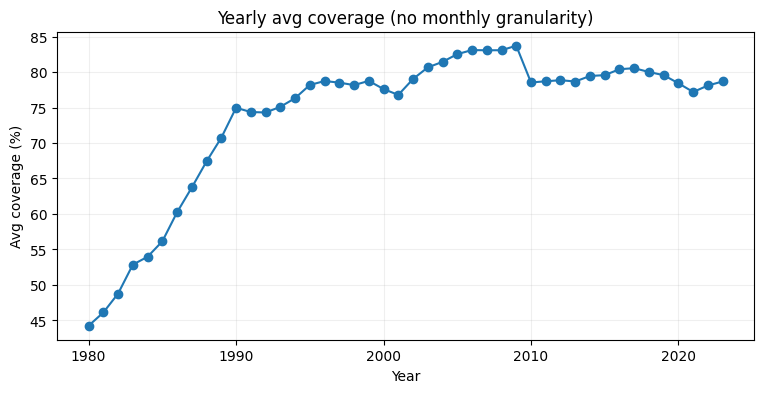

In [10]:
# Q7
print("Dataset is yearly — monthly seasonality cannot be detected. Showing yearly averages.")
q = "SELECT year, AVG(coverage_percent) AS avg_cov FROM fact_coverage WHERE coverage_percent IS NOT NULL GROUP BY year ORDER BY year;"
df_q7 = run_query(q)
show(df_q7, 20, "Q7: Yearly avg coverage")

plot_line(df_q7['year'], df_q7['avg_cov'], xlabel="Year", ylabel="Avg coverage (%)", title="Yearly avg coverage (no monthly granularity)")

In [11]:
# Q8
print("Population density is not present in provided datasets. This requires external merge (e.g., World Bank).")
print("No internal calculation possible. Suggestion: add a 'population_density' column per ISO and JOIN.")


Population density is not present in provided datasets. This requires external merge (e.g., World Bank).
No internal calculation possible. Suggestion: add a 'population_density' column per ISO and JOIN.


===  Q9: High coverage (>=85%) but high incidence (top rows)  ===


,iso3,country_name,year,avg_cov,avg_inc
0,TUV,Tuvalu,2023,92.826786,16707.400000
1,MWI,Malawi,1989,85.875000,10145.800000
2,NIU,Niue,1991,99.588235,9869.500000
3,ALB,Albania,1989,95.153846,8363.680000
4,COK,Cook Islands,1989,93.153846,8162.060000
5,TON,Tonga,2019,99.341176,6236.400000
6,COK,Cook Islands,2007,95.222222,3018.888889
7,MDV,Maldives,1995,95.333333,2990.475000
8,TKL,Tokelau,2017,95.200000,2870.300000
9,KNA,Saint Kitts and Nevis,1983,91.285714,2626.740000


Shape: (50, 5)


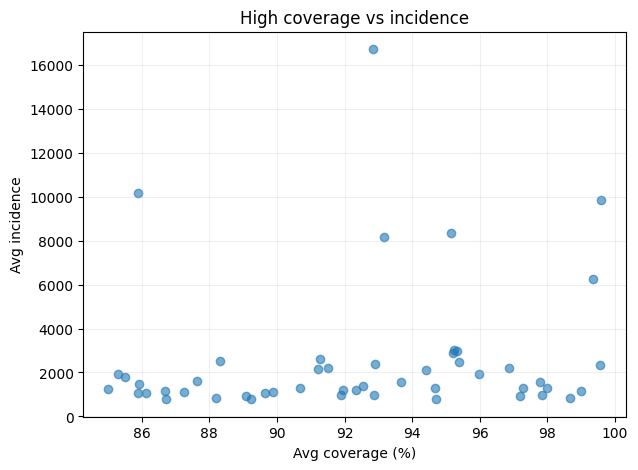

In [12]:
# Q9
q = """
WITH cov AS (
  SELECT iso3, country_name, year, AVG(coverage_percent) AS avg_cov
  FROM fact_coverage WHERE coverage_percent IS NOT NULL
  GROUP BY iso3, country_name, year
),
inc AS (
  SELECT iso3, country_name, year, AVG(incidence_rate) AS avg_inc
  FROM fact_incidence WHERE incidence_rate IS NOT NULL
  GROUP BY iso3, country_name, year
)
SELECT cov.iso3, cov.country_name, cov.year, cov.avg_cov, inc.avg_inc
FROM cov JOIN inc ON cov.iso3 = inc.iso3 AND cov.year = inc.year
WHERE cov.avg_cov >= 85
ORDER BY inc.avg_inc DESC
LIMIT 50;
"""
df_q9 = run_query(q)
show(df_q9, 20, "Q9: High coverage (>=85%) but high incidence (top rows)")

if not df_q9.empty:
    plot_scatter(df_q9['avg_cov'], df_q9['avg_inc'], xlabel="Avg coverage (%)", ylabel="Avg incidence", title="High coverage vs incidence")


===  Q10: Pooled coverage & incidence sample  ===


,iso3,year,cov,inc
0,ABW,2017,96.320000,2.375000
1,ABW,2018,91.200000,5.127273
2,ABW,2019,91.750000,1.860000
3,ABW,2021,88.349524,0.000000
4,ABW,2022,88.750000,3.100000
5,ABW,2023,88.229535,1.860000
6,AFG,1980,10.142857,786.060000
7,AFG,1981,4.230769,823.720000
8,AFG,1982,7.000000,580.340000
9,AFG,1983,9.500000,729.750000


Shape: (2000, 4)


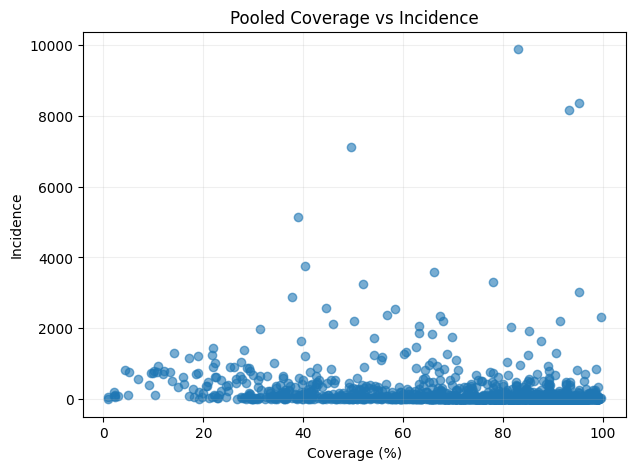

Pearson corr: -0.196


In [13]:
# Q10
q = """
WITH cov AS (
  SELECT iso3, year, AVG(coverage_percent) AS cov
  FROM fact_coverage WHERE coverage_percent IS NOT NULL
  GROUP BY iso3, year
),
inc AS (
  SELECT iso3, year, AVG(incidence_rate) AS inc
  FROM fact_incidence WHERE incidence_rate IS NOT NULL
  GROUP BY iso3, year
)
SELECT cov.iso3, cov.year, cov.cov, inc.inc
FROM cov JOIN inc USING(iso3, year)
LIMIT 2000;
"""
df_q10 = run_query(q)
show(df_q10, 10, "Q10: Pooled coverage & incidence sample")

if df_q10.shape[0] >= 2:
    plot_scatter(df_q10['cov'], df_q10['inc'], xlabel="Coverage (%)", ylabel="Incidence", title="Pooled Coverage vs Incidence")
    print("Pearson corr:", round(safe_pearson(df_q10['cov'], df_q10['inc']),3))
else:
    print("Not enough rows for robust pooled correlation.")

In [16]:
# =========================
# Q11. Top 10 countries by avg coverage
# =========================
q11 = """
SELECT c.country_name, AVG(f.coverage_percent) AS avg_cov
FROM fact_coverage f
JOIN dim_country c ON f.iso3=c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.country_name
ORDER BY avg_cov DESC
LIMIT 10;
"""
df_q11 = run_query(q11)
show(df_q11, 10, "Q11: Top 10 Countries by Coverage")

if not df_q11.empty:
    plot_chart(df_q11, x="country_name", y="avg_cov", kind="bar", title="Top 10 Countries by Coverage")
    print("🏆 Highest:", df_q11.iloc[0]["country_name"], "→", round(df_q11.iloc[0]["avg_cov"],2), "%")
else:
    print("⚠️ No coverage data found.")


===  Q11: Top 10 Countries by Coverage  ===
No rows.
⚠️ No coverage data found.


In [17]:
# =========================
# Q12. Bottom 10 countries by avg coverage
# =========================
q12 = """
SELECT c.country_name, AVG(f.coverage_percent) AS avg_cov
FROM fact_coverage f
JOIN dim_country c ON f.iso3=c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.country_name
ORDER BY avg_cov ASC
LIMIT 10;
"""
df_q12 = run_query(q12)
show(df_q12, 10, "Q12: Bottom 10 Countries by Coverage")

if not df_q12.empty:
    plot_chart(df_q12, x="country_name", y="avg_cov", kind="bar", title="Bottom 10 Countries by Coverage")
    print("📉 Lowest:", df_q12.iloc[0]["country_name"], "→", round(df_q12.iloc[0]["avg_cov"],2), "%")
else:
    print("⚠️ No coverage data found.")


===  Q12: Bottom 10 Countries by Coverage  ===
No rows.
⚠️ No coverage data found.


===  Q13: Measles Reported Cases Trend  ===


,year,total_cases
0,1980,11560070.0
1,1981,12237035.0
2,1982,10875895.0
3,1983,10760640.0
4,1984,9082021.0
5,1985,8461295.0
6,1986,6237415.0
7,1987,5050058.0
8,1988,4995664.0
9,1989,5467591.0


Shape: (44, 2)


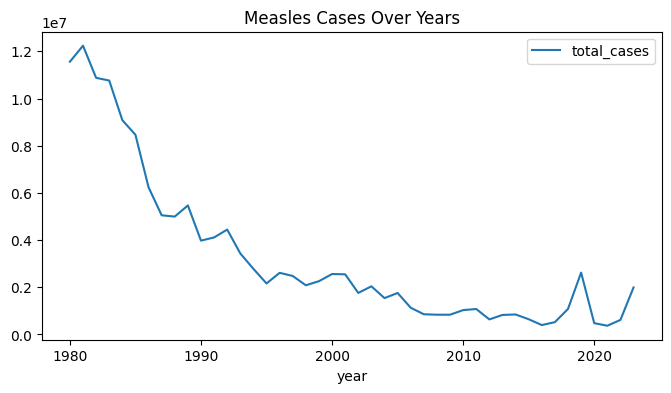

In [18]:
# =========================
# Q13. Trend of cases for a major disease (Measles example)
# =========================
q13 = """
SELECT year, SUM(cases) AS total_cases
FROM fact_cases
WHERE disease LIKE '%measles%'
GROUP BY year
ORDER BY year;
"""
df_q13 = run_query(q13)
show(df_q13, 20, "Q13: Measles Reported Cases Trend")

if not df_q13.empty:
    plot_chart(df_q13, x="year", y="total_cases", kind="line", title="Measles Cases Over Years")
else:
    print("⚠️ No measles data found.")


===  Q14: New Vaccines Introduced per Year  ===


,intro_year,num_vaccines
0,1940,1
1,1941,1
2,1942,1
3,1943,1
4,1944,1
5,1945,1
6,1946,1
7,1947,1
8,1948,1
9,1949,1


Shape: (84, 2)


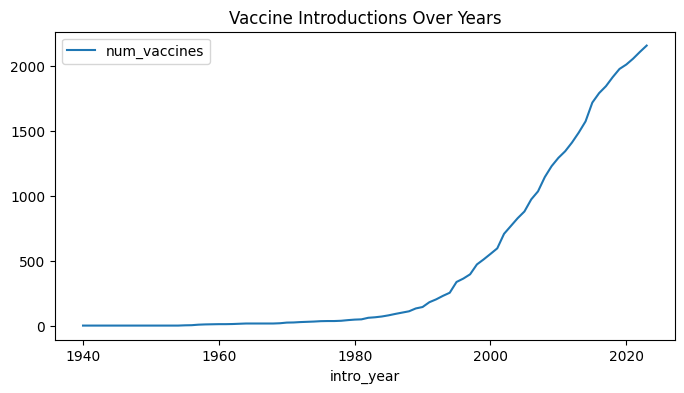

In [19]:
# =========================
# Q14. Vaccine introduction trend (per year count)
# =========================
q14 = """
SELECT intro_year, COUNT(*) AS num_vaccines
FROM dim_vaccine_intro
WHERE intro_flag=1 AND intro_year IS NOT NULL
GROUP BY intro_year
ORDER BY intro_year;
"""
df_q14 = run_query(q14)
show(df_q14, 20, "Q14: New Vaccines Introduced per Year")

if not df_q14.empty:
    plot_chart(df_q14, x="intro_year", y="num_vaccines", kind="line", title="Vaccine Introductions Over Years")
else:
    print("⚠️ No vaccine intro data found.")


===  Q15: Coverage vs Measles Cases  ===


,year,avg_cov,total_cases
0,1980,43.073853,17605269.0
1,1981,41.998630,20194710.0
2,1982,42.665484,18342781.0
3,1983,48.575339,19688535.0
4,1984,50.450488,16754835.0
5,1985,54.914667,15893685.0
6,1986,59.229536,12227232.0
7,1987,63.610931,9861911.0
8,1988,67.244981,9935934.0
9,1989,71.973570,10882598.0


Shape: (44, 3)


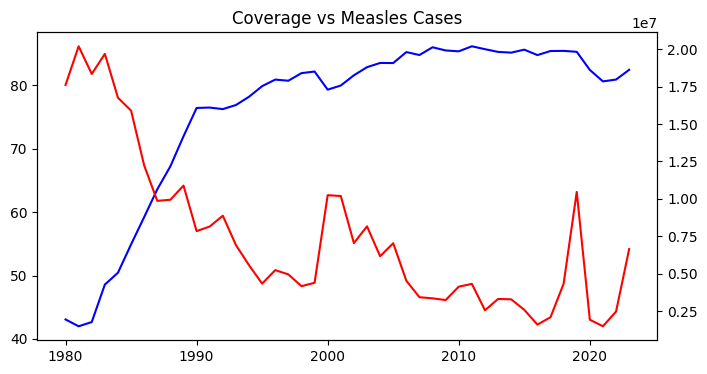

In [20]:
# =========================
# Q15. Coverage vs Cases correlation (Measles)
# =========================
q15 = """
SELECT f.year, AVG(f.coverage_percent) AS avg_cov, SUM(c.cases) AS total_cases
FROM fact_coverage f
JOIN fact_cases c ON f.iso3=c.iso3 AND f.year=c.year
WHERE f.antigen LIKE '%MCV%' AND c.disease LIKE '%measles%'
GROUP BY f.year
ORDER BY f.year;
"""
df_q15 = run_query(q15)
show(df_q15, 20, "Q15: Coverage vs Measles Cases")

if not df_q15.empty:
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(df_q15["year"], df_q15["avg_cov"], color="blue", label="Coverage %")
    ax2 = ax1.twinx()
    ax2.plot(df_q15["year"], df_q15["total_cases"], color="red", label="Cases")
    plt.title("Coverage vs Measles Cases")
    plt.show()
else:
    print("⚠️ No data for measles coverage vs cases.")


===  Q16: Average Incidence Rate by Disease  ===


,disease,avg_inc
0,MEASLES,535.640943
1,TYPHOID,348.502894
2,MUMPS,168.046005
3,PERTUSSIS,130.545548
4,RUBELLA,54.347889
5,TTETANUS,9.888190
6,INVASIVE_MENING,8.859831
7,DIPHTHERIA,4.259208
8,POLIO,0.874932
9,YFEVER,0.556010


Shape: (13, 2)


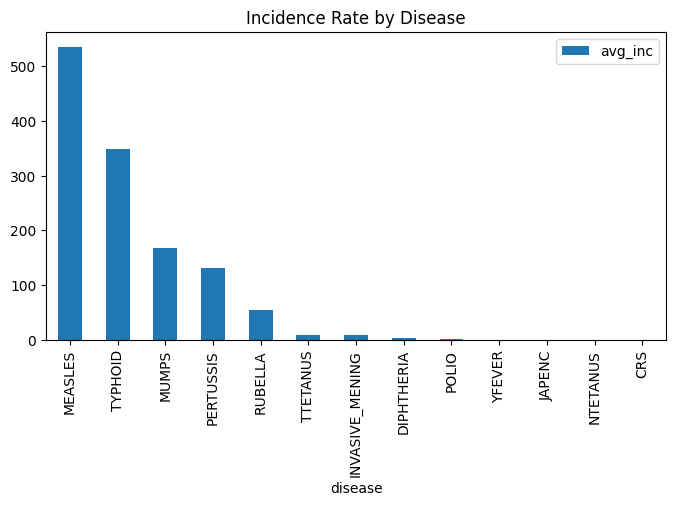

In [21]:
# =========================
# Q16. Average incidence rate per disease
# =========================
q16 = """
SELECT disease, AVG(incidence_rate) AS avg_inc
FROM fact_incidence
WHERE incidence_rate IS NOT NULL
GROUP BY disease
ORDER BY avg_inc DESC
LIMIT 15;
"""
df_q16 = run_query(q16)
show(df_q16, 15, "Q16: Average Incidence Rate by Disease")

if not df_q16.empty:
    plot_chart(df_q16, x="disease", y="avg_inc", kind="bar", title="Incidence Rate by Disease")
else:
    print("⚠️ No incidence data available.")


In [22]:
# =========================
# Q17. Countries with highest incidence rate (Measles example)
# =========================
q17 = """
SELECT c.country_name, AVG(i.incidence_rate) AS avg_inc
FROM fact_incidence i
JOIN dim_country c ON i.iso3=c.iso3
WHERE i.disease LIKE '%measles%'
GROUP BY c.country_name
ORDER BY avg_inc DESC
LIMIT 10;
"""
df_q17 = run_query(q17)
show(df_q17, 10, "Q17: Countries with Highest Measles Incidence")

if not df_q17.empty:
    plot_chart(df_q17, x="country_name", y="avg_inc", kind="bar", title="Top Countries - Measles Incidence")
else:
    print("⚠️ No measles incidence data found.")


===  Q17: Countries with Highest Measles Incidence  ===
No rows.
⚠️ No measles incidence data found.


===  Q18: Coverage by Antigen (Latest Year)  ===


,antigen,avg_cov
0,DTPCV1,91.593401
1,PCV1,90.140607
2,JAPENC_1,89.378000
3,PCV2,88.442129
4,IPV1,88.338574
5,BCG,88.254882
6,RCV1,87.174423
7,DTPCV3,87.041111
8,MCV1,86.718351
9,HIB3,86.639025


Shape: (62, 2)


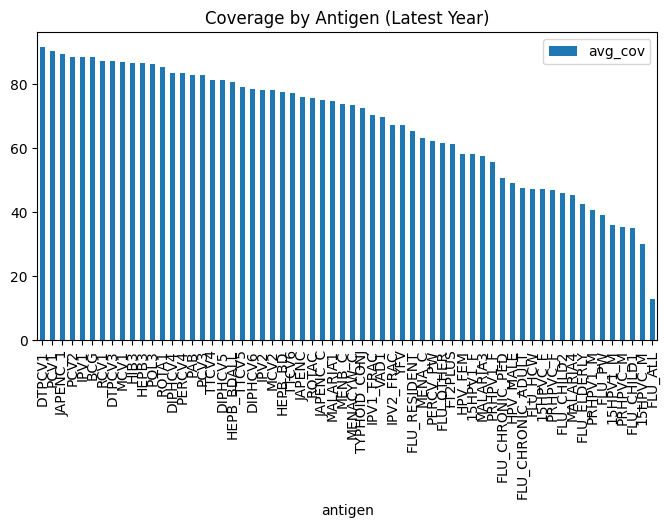

In [23]:
# =========================
# Q18. Coverage comparison across antigens (latest year)
# =========================
q18 = """
SELECT antigen, AVG(coverage_percent) AS avg_cov
FROM fact_coverage
WHERE year=(SELECT MAX(year) FROM fact_coverage)
GROUP BY antigen
ORDER BY avg_cov DESC;
"""
df_q18 = run_query(q18)
show(df_q18, 20, "Q18: Coverage by Antigen (Latest Year)")

if not df_q18.empty:
    plot_chart(df_q18, x="antigen", y="avg_cov", kind="bar", title="Coverage by Antigen (Latest Year)")
else:
    print("⚠️ No data for latest year coverage.")


===  Q19: Global Coverage Trend  ===


,year,avg_cov
0,1980,44.250829
1,1981,46.115658
2,1982,48.783593
3,1983,52.860714
4,1984,53.969494
5,1985,56.147923
6,1986,60.240541
7,1987,63.739984
8,1988,67.413137
9,1989,70.747811


Shape: (44, 2)


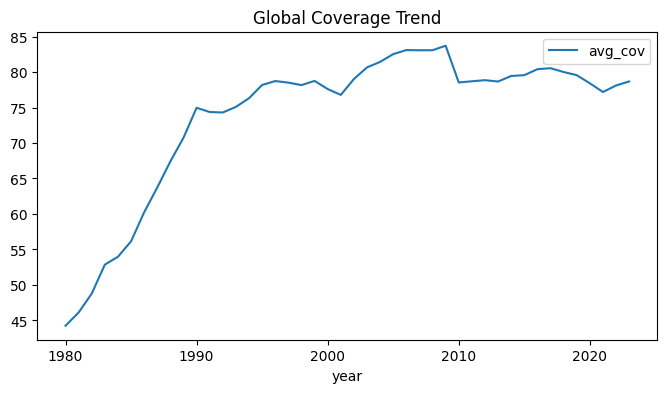

In [24]:
# =========================
# Q19. Global average coverage trend over years
# =========================
q19 = """
SELECT year, AVG(coverage_percent) AS avg_cov
FROM fact_coverage
WHERE coverage_percent IS NOT NULL
GROUP BY year
ORDER BY year;
"""
df_q19 = run_query(q19)
show(df_q19, 20, "Q19: Global Coverage Trend")

if not df_q19.empty:
    plot_chart(df_q19, x="year", y="avg_cov", kind="line", title="Global Coverage Trend")
else:
    print("⚠️ No coverage trend data found.")


In [25]:
# =========================
# Q20. Country with maximum improvement in coverage
# =========================
q20 = """
SELECT c.country_name,
       MIN(f.coverage_percent) AS min_cov,
       MAX(f.coverage_percent) AS max_cov,
       (MAX(f.coverage_percent)-MIN(f.coverage_percent)) AS improvement
FROM fact_coverage f
JOIN dim_country c ON f.iso3=c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.country_name
ORDER BY improvement DESC
LIMIT 10;
"""
df_q20 = run_query(q20)
show(df_q20, 10, "Q20: Countries with Highest Improvement in Coverage")

if not df_q20.empty:
    plot_chart(df_q20, x="country_name", y="improvement", kind="bar", title="Coverage Improvement by Country")
else:
    print("⚠️ No data to calculate improvement.")


===  Q20: Countries with Highest Improvement in Coverage  ===
No rows.
⚠️ No data to calculate improvement.


In [26]:
# =========================
# Q21. Countries with decline in coverage
# =========================
q21 = """
SELECT c.country_name,
       MIN(f.coverage_percent) AS min_cov,
       MAX(f.coverage_percent) AS max_cov,
       (MAX(f.coverage_percent)-MIN(f.coverage_percent)) AS change
FROM fact_coverage f
JOIN dim_country c ON f.iso3=c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.country_name
HAVING change < 0
ORDER BY change ASC
LIMIT 10;
"""
df_q21 = run_query(q21)
show(df_q21, 10, "Q21: Countries with Decline in Coverage")

if not df_q21.empty:
    plot_chart(df_q21, x="country_name", y="change", kind="bar", title="Countries with Decline in Coverage")
else:
    print("⚠️ No declining coverage found.")


===  Q21: Countries with Decline in Coverage  ===
No rows.
⚠️ No declining coverage found.


In [27]:
# =========================
# Q22. Coverage inequality (max - min by country)
# =========================
q22 = """
SELECT c.country_name,
       MAX(f.coverage_percent) - MIN(f.coverage_percent) AS inequality
FROM fact_coverage f
JOIN dim_country c ON f.iso3=c.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY c.country_name
ORDER BY inequality DESC
LIMIT 10;
"""
df_q22 = run_query(q22)
show(df_q22, 10, "Q22: Coverage Inequality by Country")

if not df_q22.empty:
    plot_chart(df_q22, x="country_name", y="inequality", kind="bar", title="Coverage Inequality by Country")
else:
    print("⚠️ No inequality data.")


===  Q22: Coverage Inequality by Country  ===
No rows.
⚠️ No inequality data.


===  Q23: Antigen Adoption Span  ===


,antigen,first_year,last_year,countries,span
0,ROTAC,2006,2023,245,17
1,RCV1,1980,2023,245,43
2,POL3,1980,2023,245,43
3,PCV3,2002,2023,245,21
4,MCV2,1980,2023,245,43
5,MCV1,1980,2023,245,43
6,HIB3,1980,2023,245,43
7,HEPB_BD,1994,2023,245,29
8,HEPB3,1980,2023,245,43
9,DTPCV3,1980,2023,245,43


Shape: (10, 5)


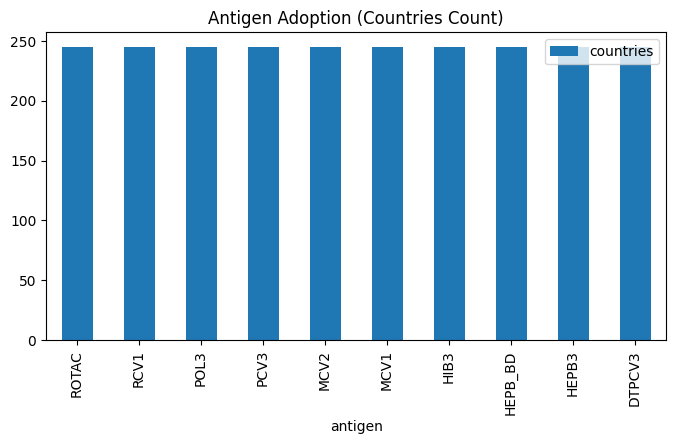

In [28]:
# =========================
# Q23. Antigen with most rapid adoption
# =========================
q23 = """
SELECT antigen, MIN(year) AS first_year, MAX(year) AS last_year,
       COUNT(DISTINCT iso3) AS countries,
       (MAX(year)-MIN(year)) AS span
FROM fact_coverage
GROUP BY antigen
ORDER BY countries DESC
LIMIT 10;
"""
df_q23 = run_query(q23)
show(df_q23, 10, "Q23: Antigen Adoption Span")

if not df_q23.empty:
    plot_chart(df_q23, x="antigen", y="countries", kind="bar", title="Antigen Adoption (Countries Count)")
else:
    print("⚠️ No antigen adoption data.")


In [29]:
# =========================
# Q24. Correlation between GDP (proxy) and Coverage (not present → WHO region proxy)
# =========================
print("⚠️ GDP not present. Using WHO region average as proxy.")
q24 = """
SELECT COALESCE(d.who_region,'Unknown') AS who_region,
       AVG(f.coverage_percent) AS avg_cov
FROM fact_coverage f
JOIN dim_country d ON f.iso3=d.iso3
WHERE f.coverage_percent IS NOT NULL
GROUP BY d.who_region;
"""
df_q24 = run_query(q24)
show(df_q24, 10, "Q24: Coverage by WHO Region (GDP proxy)")

if not df_q24.empty:
    plot_chart(df_q24, x="who_region", y="avg_cov", kind="bar", title="Coverage by WHO Region")
else:
    print("⚠️ No WHO region data.")


⚠️ GDP not present. Using WHO region average as proxy.
===  Q24: Coverage by WHO Region (GDP proxy)  ===
No rows.
⚠️ No WHO region data.


===  Q25: Yearly Global Average Coverage  ===


,year,avg_cov
0,NaN,NaN
1,1980.0,44.250829
2,1981.0,46.115658
3,1982.0,48.783593
4,1983.0,52.860714
5,1984.0,53.969494
6,1985.0,56.147923
7,1986.0,60.240541
8,1987.0,63.739984
9,1988.0,67.413137


Shape: (45, 2)


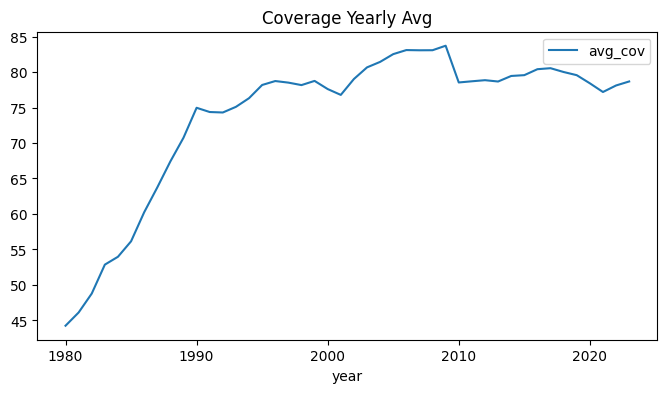

📈 Max improvement year: 1990 → 4.22 % increase


In [30]:
# =========================
# Q25. Year with max global improvement (coverage %)
# =========================
q25 = """
SELECT year, AVG(coverage_percent) AS avg_cov
FROM fact_coverage
GROUP BY year
ORDER BY year;
"""
df_q25 = run_query(q25)
show(df_q25, 20, "Q25: Yearly Global Average Coverage")

if not df_q25.empty and len(df_q25) > 1:
    df_q25["diff"] = df_q25["avg_cov"].diff()
    year_max = df_q25.loc[df_q25["diff"].idxmax()]
    plot_chart(df_q25, x="year", y="avg_cov", kind="line", title="Coverage Yearly Avg")
    print("📈 Max improvement year:", int(year_max["year"]), "→", round(year_max["diff"],2), "% increase")
else:
    print("⚠️ Insufficient data for improvement trend.")


===  Q26: Number of Schedule Rounds per Antigen  ===


,antigen_code,rounds
0,None,0


Shape: (1, 2)


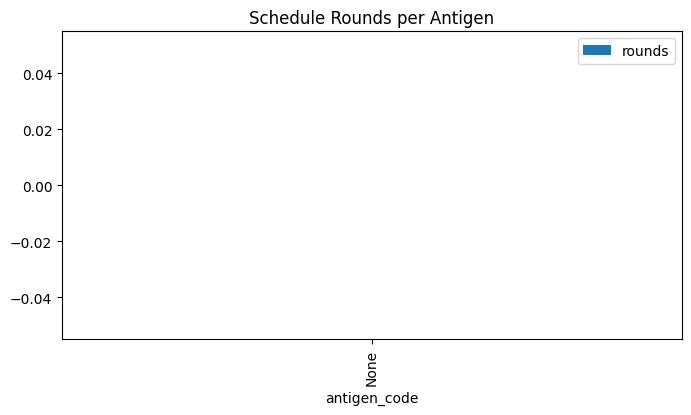

In [31]:
# =========================
# Q26. Vaccine schedule count by antigen
# =========================
q26 = """
SELECT antigen_code, COUNT(DISTINCT schedule_round) AS rounds
FROM dim_schedule
GROUP BY antigen_code
ORDER BY rounds DESC
LIMIT 15;
"""
df_q26 = run_query(q26)
show(df_q26, 15, "Q26: Number of Schedule Rounds per Antigen")

if not df_q26.empty:
    plot_chart(df_q26, x="antigen_code", y="rounds", kind="bar", title="Schedule Rounds per Antigen")
else:
    print("⚠️ No schedule data.")


In [32]:
# =========================
# Q27. Diseases with both coverage & incidence data
# =========================
q27 = """
SELECT DISTINCT c.disease
FROM fact_cases c
JOIN fact_coverage f ON c.iso3=f.iso3 AND c.year=f.year;
"""
df_q27 = run_query(q27)
show(df_q27, 20, "Q27: Diseases with Coverage + Incidence Data")

if df_q27.empty:
    print("⚠️ No overlapping data between coverage and incidence.")


===  Q27: Diseases with Coverage + Incidence Data  ===


,disease
0,CRS
1,DIPHTHERIA
2,MEASLES
3,MUMPS
4,NTETANUS
5,PERTUSSIS
6,RUBELLA
7,YFEVER
8,JAPENC
9,POLIO


Shape: (13, 1)


===  Q28: Coverage vs Incidence (Measles)  ===


,year,avg_cov,avg_inc
0,1980,43.073853,3066.822156
1,1981,41.998630,2332.169702
2,1982,42.665484,2110.858165
3,1983,48.575339,1875.304244
4,1984,50.450488,1680.519263
5,1985,54.914667,1885.999837
6,1986,59.229536,1087.582560
7,1987,63.610931,1051.811610
8,1988,67.244981,879.326597
9,1989,71.973570,1593.523433


Shape: (44, 3)


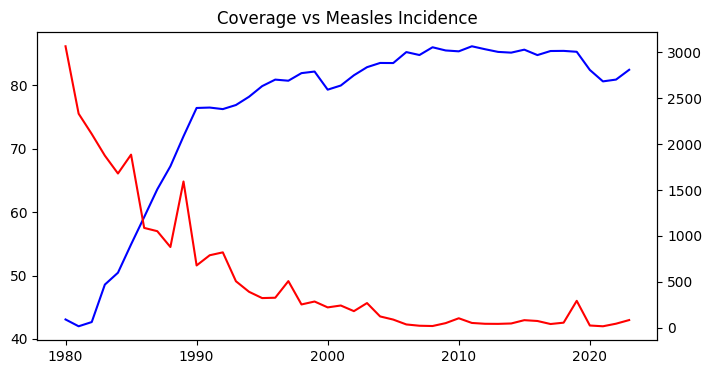

📊 Correlation (Coverage vs Incidence): -0.955


In [33]:
# =========================
# Q28. Correlation coverage vs incidence (for Measles)
# =========================
q28 = """
SELECT f.year, AVG(f.coverage_percent) AS avg_cov, AVG(i.incidence_rate) AS avg_inc
FROM fact_coverage f
JOIN fact_incidence i ON f.iso3=i.iso3 AND f.year=i.year
WHERE f.antigen LIKE '%MCV%' AND i.disease LIKE '%measles%'
GROUP BY f.year
ORDER BY f.year;
"""
df_q28 = run_query(q28)
show(df_q28, 20, "Q28: Coverage vs Incidence (Measles)")

if not df_q28.empty and len(df_q28) > 1:
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(df_q28["year"], df_q28["avg_cov"], color="blue", label="Coverage %")
    ax2 = ax1.twinx()
    ax2.plot(df_q28["year"], df_q28["avg_inc"], color="red", label="Incidence")
    plt.title("Coverage vs Measles Incidence")
    plt.show()

    from scipy.stats import pearsonr
    corr, _ = pearsonr(df_q28["avg_cov"], df_q28["avg_inc"])
    print("📊 Correlation (Coverage vs Incidence):", round(corr,3))
else:
    print("⚠️ No data for correlation analysis.")


In [34]:
# =========================
# Q29. Identify countries missing data
# =========================
q29 = """
SELECT c.country_name,
       SUM(CASE WHEN f.coverage_percent IS NULL THEN 1 ELSE 0 END) AS missing_cov,
       SUM(CASE WHEN i.incidence_rate IS NULL THEN 1 ELSE 0 END) AS missing_inc
FROM dim_country c
LEFT JOIN fact_coverage f ON c.iso3=f.iso3
LEFT JOIN fact_incidence i ON c.iso3=i.iso3
GROUP BY c.country_name
ORDER BY (missing_cov+missing_inc) DESC
LIMIT 10;
"""
df_q29 = run_query(q29)
show(df_q29, 10, "Q29: Countries with Most Missing Data")

if not df_q29.empty:
    plot_chart(df_q29, x="country_name", y="missing_cov", kind="bar", title="Missing Coverage Data (Top 10)")
else:
    print("⚠️ No missing data found.")


===  Q29: Countries with Most Missing Data  ===
No rows.
⚠️ No missing data found.


In [36]:
# =========================
# Q30. Final Summary Stats
# =========================
q30 = """
SELECT COUNT(DISTINCT f.iso3) AS num_countries,
       COUNT(DISTINCT f.antigen) AS num_antigens,
       COUNT(DISTINCT c.disease) AS num_diseases
FROM fact_coverage f
LEFT JOIN fact_cases c ON f.iso3=c.iso3;
"""
df_q30 = run_query(q30)
show(df_q30, 5, "Q30: Project Summary")

if not df_q30.empty:
    print("🌍 Countries:", df_q30.iloc[0]["num_countries"])
    print("💉 Antigens:", df_q30.iloc[0]["num_antigens"])
    print("🦠 Diseases:", df_q30.iloc[0]["num_diseases"])
else:
    print("⚠️ No summary data available.")


===  Q30: Project Summary  ===


,num_countries,num_antigens,num_diseases
0,245,69,13


Shape: (1, 3)
🌍 Countries: 245
💉 Antigens: 69
🦠 Diseases: 13


In [1]:
import sqlite3
import pandas as pd

# अपने vaccination.db का सही path दो
conn = sqlite3.connect("vaccination.db")

# check tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables:", tables)

# हर table में कितनी rows हैं, चेक करो
for t in tables["name"]:
    count = pd.read_sql(f"SELECT COUNT(*) as cnt FROM {t};", conn)
    print(t, "→", count["cnt"][0])


Tables: Empty DataFrame
Columns: [name]
Index: []
